In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import (Input, Dense, Embedding, LSTM, GRU, Bidirectional, 
                        SpatialDropout1D,  GlobalMaxPooling1D, Concatenate, 
                        Conv1D, Dropout, BatchNormalization, Activation)
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from keras.models import Model
from keras import backend as K

print('Keras version', keras.__version__)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

Keras version 2.2.2
['train.tsv', 'test.tsv', 'sampleSubmission.csv']


## Quick analysis

Data is a set of sentences labeled with sentiments from 0 (negative) to 4 (positive). 

In [50]:
train = pd.read_csv('../input/train.tsv',  sep="\t")
test = pd.read_csv('../input/test.tsv',  sep="\t")

In [51]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


As we can see sentences are divided into phrases to analyse. Sometimes a phrase consists of just a word. Let take a look how the sentence number 10 is represented in the data:

In [53]:
train.loc[train.SentenceId == 10]

,PhraseId,SentenceId,Phrase,Sentiment
259,260,10,You could hate it for the same reason .,1
260,261,10,could hate it for the same reason .,1
261,262,10,could hate it for the same reason,0
262,263,10,could,2
263,264,10,hate it for the same reason,1
264,265,10,hate it,0
265,266,10,hate,0
266,267,10,for the same reason,2
267,268,10,the same reason,2
268,269,10,same reason,2


In [54]:
print('average phrase length is', train['Phrase'].str.len().mean())
print('max phrase length is', train['Phrase'].str.len().max())

average phrase length is 40.217224144559786
max phrase length is 283


Number of unique words in the set:

Labels are distributed as follows:

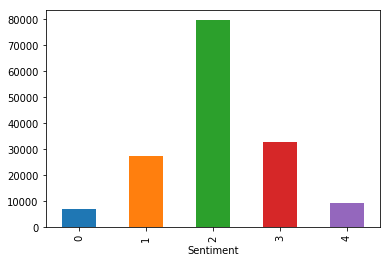

In [75]:
x = train.groupby(['Sentiment'])['PhraseId'].count()
x.plot.bar()

As we can see most of the phrases are neutral or close to neutral, which makes them more difficult to classify.

## Preprocessing

In [77]:
def preprocessing(train, test, max_len=MAX_LEN, max_features=MAX_FEATURES, train_size=0.8):
    """
        https://www.kaggle.com/antmarakis/cnn-baseline-model
    """
    #lower
    X = train['Phrase'].apply(lambda x: x.lower())
    X_test = test['Phrase'].apply(lambda x: x.lower())
    
    #tokenizing
    X = X.values.tolist()
    X_test = X_test.values.tolist()
    X_tok = X + X_test
    tokenizer = Tokenizer(num_words=max_features, filters='')
    tokenizer.fit_on_texts(X_tok)
    
    X = tokenizer.texts_to_sequences(X)
    X_test = tokenizer.texts_to_sequences(X_test)
    
    #add zero padding to the left
    X = pad_sequences(X, maxlen=max_len)
    X_test = pad_sequences(X_test, maxlen=max_len)
    
    word_index = tokenizer.word_index
    
    y = train['Sentiment'].values
        
    Y = to_categorical(y)
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          Y,
                                                          train_size=train_size,
                                                          shuffle=True,
                                                          random_state=RANDOM_STATE,
                                                          stratify=y)
    #loss_weights = [1/5 for _ in range(5)]
    
    return X_train, X_valid, y_train, y_valid, X_test, loss_weights, word_index

## Models

In [74]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

def make_model_cnn ():
    model = Sequential()

    # Input / Embdedding
    model.add(Embedding(MAX_FEATURES, 150, input_length=MAX_LEN))

    # CNN
    model.add(SpatialDropout1D(0.2))

    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    

    model.add(Flatten())

    # Output layer
    model.add(Dense(5, activation='sigmoid'))
    return model

In [78]:
def make_model_lstm_cnn():
    model=Sequential()
    #Input/Embedding
    model.add(Embedding(MAX_FEATURES, 150, input_length=MAX_LEN))
    
    #LSTM
    model.add(LSTM(128,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
    model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
    
    #CNN
    model.add(SpatialDropout1D(0.2))

    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    #Dense/Output
    model.add(Dense(5,activation='sigmoid'))
    
    return model

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])

In [79]:
#s = reset_tf_session()  # clear default graph
model = make_model_lstm_cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 150)          3750000   
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 128)          142848    
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 64)           49408     
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 64)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 100, 64)           12352     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 50, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 50, 128)           24704     
__________

In [82]:
MAX_LEN = 100
EMBEDDING_DIM = 300
MAX_FEATURES = 25000
RANDOM_STATE = 123
EPOCHS = 10
BATCH_SIZE = 128

In [80]:
X_train, X_valid, y_train, y_valid, X_test, loss_weights, word_index = preprocessing(train, test)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

In [ ]:
sub = pd.read_csv('../input/sampleSubmission.csv')

sub['Sentiment'] = model.predict_classes(test_X, batch_size=batch_size, verbose=1)
sub.to_csv('sub_cnn.csv', index=False)